## Two Site 1D Hubbard QITE
This notebook is a guide to implement QITE on the Fermi-Hubbard model with two sites

We will refer to Pauli matrices by their indices: $[I, X, Y, Z] \equiv [0, 1, 2, 3]$
For consistency in notation, we use the following mapping for 2-qubit operators, composed of a Pauli matrices acting on each qubit. This is the indexing used throughout the code.

In [22]:
pauli_indices = [0, 1, 2, 3]
pauli_pairs = [(i, j) for i in pauli_indices for j in pauli_indices]
print(pauli_pairs)
pauli_pair_dict = {pauli_pairs[i] : i for i in range(len(pauli_pairs))}
print(pauli_pair_dict)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 13, (3, 2): 14, (3, 3): 15}


We define a measurement function **measure** and a propagation function **propagate**

In **measure** we define circuits to measure the expectation value of any Pauli string

In **propagate**, we loop through the different values store in alist to construct the states. alist is stored as a list of lists and the indices are $a[timestep][gate]$. For a timestep $\Delta \tau$, the gate indices of $a$ correspond to:

$$
a[0]=e^{-ia[II]\Delta\tau\hat{I} \otimes \hat{I}} \text{,  } \; 
a[1]=e^{-ia[IX]\Delta\tau\hat{I} \otimes \hat{X}} \text{,  } \;
a[2]=e^{-ia[IY]\Delta\tau\hat{I} \otimes \hat{Y}} \text{,  } \;
a[3]=e^{-ia[ZZ]\Delta\tau\hat{I} \otimes \hat{Z}}
$$
$$
a[4]=e^{-ia[XI]\Delta\tau\hat{X} \otimes \hat{I}} \text{,  } \; 
a[5]=e^{-ia[XX]\Delta\tau\hat{X} \otimes \hat{X}} \text{,  } \;
a[6]=e^{-ia[XY]\Delta\tau\hat{X} \otimes \hat{Y}} \text{,  } \;
a[7]=e^{-ia[XZ]\Delta\tau\hat{X} \otimes \hat{Z}}
$$
$$
a[8]=e^{-ia[YI]\Delta\tau\hat{Y} \otimes \hat{I}} \text{,  } \; 
a[9]=e^{-ia[YX]\Delta\tau\hat{Y} \otimes \hat{X}} \text{,  } \;
a[10]=e^{-ia[YY]\Delta\tau\hat{Y} \otimes \hat{Y}} \text{,  } \;
a[11]=e^{-ia[YZ]\Delta\tau\hat{Y} \otimes \hat{Z}}
$$
$$
a[12]=e^{-ia[ZI]\Delta\tau\hat{Z} \otimes \hat{I}} \text{,  } \; 
a[13]=e^{-ia[ZX]\Delta\tau\hat{Z} \otimes \hat{X}} \text{,  } \;
a[14]=e^{-ia[ZY]\Delta\tau\hat{Z} \otimes \hat{Y}} \text{,  } \;
a[15]=e^{-ia[ZZ]\Delta\tau\hat{Z} \otimes \hat{Z}}
$$

The 0 index stores the coefficient for the identity matrix $\hat{I}$ on both qubits, which is a global phase for each qubit that we can ignore.

In [23]:
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs,correct_bitstring_probs
from pyquil import Program,get_qc

def measure(p, ro, idx, qc, qbits):
    # Circuit to measure the expectation value of any Pauli string
    # For 2-qubit Pauli measurements, see https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements
    # initialize qc    
    qc = get_qc(qc)
    # measure II
    if idx == 0:
        return 1
    # measure IX
    elif idx == 1:
        p += SWAP(qbits[0], qbits[1])
        p += H(qbits[0])
    # measure IY
    elif idx == 2:
        p += SWAP(qbits[0], qbits[1])
        p += RX(np.pi/2, qbits[0])
    # measure IZ
    elif idx == 3:
        p += SWAP(qbits[0], qbits[1])

    # measure XI
    elif idx == 4:
        p += H(qbits[0])
    # measure XX
    elif idx == 5:
        p += H(qbits[0])
        p += H(qbits[1])
        p += CNOT(qbits[1], qbits[0])
    # measure XY
    elif idx == 6:
        p += H(qbits[0])
        p += RX(np.pi/2, qbits[1])
        p += CNOT(qbits[1], qbits[0])
    # measure XZ
    elif idx == 7:
        p += H(qbits[0])
        p += CNOT(qbits[1], qbits[0])
    # measure YI
    elif idx == 8:
        p += RX(np.pi/2, qbits[0])
    # measure YX
    elif idx == 9:
        p += RX(np.pi/2, qbits[0])
        p += H(qbits[1])
        p += CNOT(qbits[1], qbits[0])
    # measure YY
    elif idx == 10:
        p += RX(np.pi/2, qbits[0])
        p += RX(np.pi/2, qbits[1])
        p += CNOT(qbits[1], qbits[0])
    #measure YZ
    elif idx == 11:
        p += RX(np.pi/2, qbits[0])
        p += CNOT(qbits[1], qbits[0])
    # measure ZI
    elif idx == 12:
        return 1
    # measure ZX
    elif idx == 13:
        p += H(qbits[1])
        p += CNOT(qbits[1], qbits[0])
    # measure ZY
    elif idx == 14:
        p += RX(np.pi/2, qbits[1])
        p += CNOT(qbits[1], qbits[0])
    # measure ZZ
    elif idx == 15:
        p += CNOT(qbits[1], qbits[0])
    # oops
    else:
        raise ValueError

    p += MEASURE(qbits[0], ro[0])
    exe = qc.compile(p)
    res = qc.run(exe)
    probs = estimate_bitstring_probs(res)
    # probs = correct_bitstring_probs(probs,[correction_matrix])
    return probs[0] - probs[1]


In [24]:
def applyPhase(p,qbits,angle):
    p += CNOT(qbits[0],qbits[1])
    p += RZ(angle,qbits[1])
    p += CNOT(qbits[0],qbits[1])

In [25]:
def propagate(p,alist,qbits):
    # Circuit to propagate the state
    if len(alist) == 0:
        None
    else:
        for t in range(len(alist)):
            
            for i in range(1,16):
                angle = np.real(alist[t][i])
                # II... we skip this case because it's just a phase
                if i == 0:
                    continue
                # IX
                elif i == 1:
                    p += RX(angle,qbits[1])

                # IY
                elif i == 2:
                    p += RY(angle,qbits[1])

                # IZ
                elif i == 3:
                    p += RZ(angle,qbits[1])

                # XI
                elif i == 4:
                    p += RX(angle,qbits[0])
                    
                # XX
                elif i == 5:
                    p += H(qbits[0])
                    p += H(qbits[1])
                    applyPhase(p,qbits,angle)
                    p += H(qbits[1])
                    p += H(qbits[0])
                    
                # XY
                elif i == 6:
                    p += H(qbits[0])
                    p += RX(np.pi/2, qbits[1])
                    applyPhase(p,qbits,angle)
                    p += RX(-np.pi/2, qbits[1])
                    p += H(qbits[0])
                    
                # XZ
                elif i == 7:
                    p += H(qbits[0])
                    applyPhase(p,qbits,angle)
                    p += H(qbits[0])
                    
                # YI
                elif i == 8:
                    p += RY(angle,qbits[0])
                    
                # YX
                elif i == 9:
                    p += RX(np.pi/2, qbits[0])
                    p += H(qbits[1])
                    applyPhase(p,qbits,angle)
                    p += H(qbits[1])
                    p += RX(-np.pi/2, qbits[0])
                    
                # YY
                elif i == 10:
                    p += RX(np.pi/2, qbits[0])
                    p += RX(np.pi/2, qbits[1])
                    applyPhase(p,qbits,angle)
                    p += RX(-np.pi/2, qbits[1])
                    p += RX(-np.pi/2, qbits[0])
                    
                # YZ
                elif i == 11:
                    p += RX(np.pi/2, qbits[0])
                    applyPhase(p,qbits,angle)
                    p += RX(-np.pi/2, qbits[0])
                    
                # ZI
                elif i == 12:
                    p += RZ(angle,qbits[0])
                    
                # ZX
                elif i == 13:
                    p += H(qbits[1])
                    applyPhase(p,qbits,angle)
                    p += H(qbits[1])
                    
                # ZY
                elif i == 14:
                    p += RX(np.pi/2, qbits[1])
                    applyPhase(p,qbits,angle)
                    p += RX(-np.pi/2, qbits[1])
                    
                # ZZ
                elif i == 15:
                    applyPhase(p,qbits,angle)
                    
                # oops
                else:
                    raise ValueError
                

We now want to obtain the coefficients a[m] at the current time step and append to alist. For the 1-qubit case, we need to construct the matrix $S_{ij} = \langle \psi | \sigma_{i} \sigma_{j} | \psi \rangle$ and the vector $b_{i}$. Well, our earlier functions allow us to measure the expectation values of the different pauli matrices. How do we obtain $S_{ij}$ from a list of $\langle \psi | \sigma | \psi \rangle$? We can exploit the fact that up to some coefficients, $\sigma_{i}\sigma_{j} = c_{ij}\sigma_{ij}$. For example, $\sigma_{x}\sigma_{y} = i\sigma_{z}$. We will need a matrix to keep track of what pauli matrix and coefficient we get for $\sigma_{i}\sigma_{j}$. These are stored in the matrices **idx** and **coeff** below.


For the 2-qubit case, we can reuse these matrices. For example,
$(X \otimes X) (X \otimes Y) = XX \otimes XY = I \otimes i Z$

In [26]:
import sys
sys.path.append('classical')

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm 
from binary_functions import Int2Bas,Bas2Int,Opp2Str,Str2Opp
from Pmn import PPmunu

In [49]:
# First populate the Lie algebra rules
index = np.zeros([4**2,4**2],dtype=int)
coeff = np.zeros([4**2,4**2],dtype=complex)

row = 0
for i in range(4**2):
    column = 0
    for j in range(4**2):
        Pnu = Opp2Str(Int2Bas(column,4,2))
        Pmu = Opp2Str(Int2Bas(row,4,2))
        A = Pmu[0] + Pnu[0]
        B = Pmu[1] + Pnu[1]
        A,intA = PPmunu(A)
        B,intB = PPmunu(B)
        index[i,j] = Bas2Int(Str2Opp(A+B),4)
        coeff[i,j] = intA*intB
        column += 1
    row += 1

We need to calculate:

$$S_{ij} = \langle \psi | Q_{i} Q_{j} | \psi \rangle = \langle \psi | ( \sigma_{i0} \otimes \sigma_{i1} ) ( \sigma_{j0} \otimes \sigma_{j1} ) | \psi \rangle = \langle \psi | \left( \sigma_{i0} \sigma_{j0} \otimes \sigma_{i1} \sigma_{j1} \right) | \psi \rangle$$

And the vector 
$$b_{i} = i \langle \psi | Q_{i} | \Delta_{0} \rangle - h.c. = i \langle \psi | {( \sigma_{i0} \otimes \sigma_{i1})} | \Delta_{0} \rangle - h.c.$$

where $| \Delta_{0} \rangle = \frac{(| \psi' \rangle - | \psi \rangle)}{\Delta \tau}$

Using this, we can construct the S matrix and b vector. We use the **idx** and **coeff** matrices and the function np.linalg.std to solve for x in **update_alist**. Because the rotation gate is defined as $e^{-i\theta/2\sigma}$, we multiply the x by 2 before storing them in alist.

In [65]:
# a matrix should be 16 x 16
def update_alist(sigma_expectation,alist,db,delta,hm):
    '''
    Obtain A[m]
    To do this, we compute the S matrix and the b vector. We also need to compute the norm c
    Details:
    Each local Hamiltonian term hm can be a sum of many 2-qubit operators...
     ... see the construction of the hm_list to see why... for each term in hm (hm[i]):
    hm[i][1][0] is the multiplicative constant in the Hamiltonian
    hm[i][0][0] is the index of the Pauli matrix for qubit 0
    hm[i][0][1] is the index of the Pauli matrix for qubit 1
    '''
    
    # c is the squared norm
    c = 1
    for i in range(len(hm)):
        hm_idx = pauli_pair_dict[(hm[i][0][0], hm[i][0][1])]
        c -= 2 * db * hm[i][1][0] * sigma_expectation[hm_idx]
    # c is now the norm, after we take its square root
    c = np.sqrt(c)
        
    # Initialize S matrix
    S = np.zeros([16, 16], dtype=complex)
    # Initialize b vector
    b = np.zeros([16], dtype=complex)
    
    for i in range(16):
        # Step 1: Obtain S matrix
        for j in range(16):
            S[i, j] = sigma_expectation[index[i,j]] * coeff[i,j]
            #print(i, j, S[i, j])
    for i in range(16):
        # Step 2: Obtain b vector
        b[i] += (sigma_expectation[i]/c-sigma_expectation[i])/(db)
        # iterate through hm terms
        for j in range(len(hm)):
            hm_idx = pauli_pair_dict[(hm[j][0][0],hm[j][0][1])]            
            b[i] -= hm[j][1][0]*coeff[i,hm_idx]*sigma_expectation[index[i,hm_idx]]/c
        b[i] = 1j*b[i] - 1j*np.conj(b[i])
        print(i, b[i])
        
    # Step 3: Add regularizer... 16 x 16 matrix with 1s on main diagonal and 0s elsewhere
    dalpha = np.eye(16)*delta

    # Step 4: Solve for linear equation, the solution is multiplied by -2 because of the definition of unitary rotation gates is exp(-i theta/2)
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]
    alist.append([])
    for i in range(len(x)):
        alist[-1].append(-x[i] * 2 * db)
    return c



Now we implement the full QITE protocol. It will be good to have a big picture of what should be done. We step through imaginary time and at each time step, we should first measure the expectation values of the pauli matrices $\sigma$. This is indicated in the first two lines of the for loop. Using the relevant expectation values, we obtain the coefficients $a[m]$ in equation (2.5) of Lecture 12 using the update rule in equation (2.9-2.11). We store it in a list and use this to propagate our state. Note we have to always reconstruct our state for each new measurements we make. Finally, we measure the current energy values. Let us construct the required functions starting with **get_expectation**. We make use of the **measure** function we constructed earlier. The key here is to propagate our state using the coefficients in alist. We do this using the **propagate** function.

In [66]:
import matplotlib.pyplot as plt
# from pyquil.gates import *
# from pyquil.noise import estimate_bitstring_probs
# from pyquil import Program,get_qc

def ansatz(p, qbits):
    None

def measure_energy(alist, shots, qc, qbits, hm_list):
    # Measure the energy at the end of each time step
    Energy = 0
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        hm = hm_list[i]
        for j in range(len(hm)):
            p = Program()
            p.wrap_in_numshots_loop(shots)
            # declare readout register with 1 bit
            ro = p.declare('ro', 'BIT', 1)
            ansatz(p, qbits)
            propagate(p, alist, qbits)
            pauli_pair = (hm[j][0][0], hm[j][0][1])
            idx = pauli_pair_dict[pauli_pair]
            tmp = hm[j][1][0] * measure(p, ro, idx, qc, qbits)
            print(tmp)
            Energy += tmp

    return Energy

def get_expectation(alist, shots, qc, qbits):
    # Obtain the expectation values of the Pauli string at each time step
    sigma_expectation = np.zeros([16], dtype=complex)
    for i in range(16):
        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        ansatz(p,qbits)
        propagate(p, alist, qbits)
        sigma_expectation[i] = measure(p, ro, i, qc, qbits)
    return sigma_expectation

def qite_step(alist, shots, qc, qbits, db, delta, hm_list):
    sigma_expectation = get_expectation(alist, shots, qc, qbits)
    for j in range(len(hm_list)):
        update_alist(sigma_expectation, alist, db, delta, hm_list[j]) # = norm
    return alist, sigma_expectation

def qite(qc, qbits, shots, db, delta, N, hm_list):
    E = np.zeros([N+1],dtype=complex)
    alist = []
    E[0] = measure_energy(alist, shots, qc, qbits, hm_list)
    print("Initial energy: ", E[0])
    # Qite main loop
    QITE_expectations = []
    for i in range(1,N+1):
        alist, sigma_expectation = qite_step(alist, shots, qc, qbits, db, delta, hm_list)
        print(sigma_expectation.real.tolist())
        QITE_expectations.append(sigma_expectation.real.tolist())
        E[i] = measure_energy(alist, shots, qc, qbits, hm_list)
#         print("a list: ", alist)
        print("energy: ", E[i])
    #print(full_sigma_expectation_list)
    return E, QITE_expectations

### Running QITE with 2-site 1D Hubbard Hamiltonian

The 2-site 1D Hubbard Hamiltonian, for a half-filled lattice (2 fermions) is:

$$ H = -t \sum_{\sigma} \left( a_{1 \sigma}^{\dagger} a_{2 \sigma} + a_{2 \sigma}^{\dagger} a_{1 \sigma} \right) + U \sum_{i=1}^{2} n_{i \uparrow} n_{i \downarrow} $$

We can solve for the ground state energy of this Hamiltonian exactly, since the Hilbert space is small enough. We expect the ground state wavefunction to be symmetric with spin up and spin down components, and the most general guess is:

$$| \psi \rangle = \alpha \left( a_{1 \uparrow}^{\dagger} a_{1 \downarrow}^{\dagger} + a_{2 \uparrow}^{\dagger} a_{2 \downarrow}^{\dagger} \right) |0 \rangle + \beta \left( a_{1 \uparrow}^{\dagger} a_{2 \downarrow}^{\dagger} + a_{1 \uparrow}^{\dagger} a_{2 \downarrow}^{\dagger} \right) |0 \rangle$$

Using the time independent Schrodinger equation $H | \psi \rangle = E | \psi \rangle$ we get the coupled equations:

$$ (E-U) \alpha + 2 t \beta = 0$$
$$2t \alpha + E \beta = 0$$

There are two solutions; the one with the lower energy is the ground state energy:

$$E_{0} = \frac{1}{2} \left( U - \sqrt{U^{2} + 16 t^{2}} \right)$$

For our simulation, we run QITE with $t=1$ and $U=2$, so our goal is to match the exact ground state energy of $E_{0} = -1.23607$

We run QITE with a two qubit QVM using the 2-site 1D Hubbard Hamiltonian, with fermionic operators mapped to Pauli matrices by the Jordan-Wigner transformation.

$$H = -t \left( X \otimes I + I \otimes X \right) + \frac{U}{2} \left( I + Z \otimes Z \right)$$

In [102]:
# ---- input parameters for qite
N = 10
shots = 8192 #8192
db = 0.1
# use a 2-qubit qvm
qc = '2q-qvm'
qbits = [0, 1]
# qbits = [1, 0]
# kinetic energy contribution
t = 1.
# potential energy contribution
U = 2.
print("t = ", t, ", U = ", U)
# construct hm_list to represent H = -t(X \otimes I + I \otimes X) + U/2 (I + Z \otimes Z)
hm_list = []
# the first term (hopping kinetic term) of H
hm_list.append([])
hm_list[0].append([[1, 0], [-t]])
hm_list[0].append([[0, 1], [-t]])

hm_list[0].append([[0, 0], [U/2]])
hm_list[0].append([[3, 3], [U/2]])


# ALIST GENERATED CLASSICALLY
alist = [[ 2.26904470e-17+0.j,  1.76271580e-14+0.j, -6.43887506e-01+0.j,
 -4.96921010e-15+0.j, -4.03010958e-14+0.j, -1.91980763e-14+0.j,
  2.25401502e-14+0.j,  4.01718534e-14+0.j, -6.43887506e-01+0.j,
 -2.27595720e-14+0.j, -1.91373853e-14+0.j, -6.43887506e-01+0.j,
 -6.24596658e-15+0.j, -1.79856130e-14+0.j, -6.43887506e-01+0.j,
  1.11845349e-14+0.j],
 
[ 7.16559722e-16-3.91649197e-17j, -5.23478514e-14-3.29492168e-15j,
 -7.21161456e-01+1.95329863e-15j, -2.87540876e-14-4.95277688e-16j,
 -2.11175420e-14-7.31785916e-15j, -1.88966652e-14-2.10300331e-15j,
 -1.49843832e-01-1.17858197e-15j,  3.35041125e-14+8.30060919e-15j,
 -7.21161456e-01-5.73808579e-15j, -1.49843832e-01+2.08042134e-15j,
 -3.69273866e-14-4.89214341e-15j, -6.70521511e-01+5.04717795e-15j,
  6.73634707e-14+4.96832538e-15j,  4.08177067e-14+2.78968324e-15j,
 -6.70521511e-01-1.42929017e-15j, -4.10426959e-14-4.47108630e-15j],
 
[-1.29396622e-17-1.74160011e-16j,  6.63066041e-15-2.18226383e-15j,
 -7.24429531e-01-3.25954541e-15j,  2.41700444e-14-7.78869959e-17j,
  5.42076900e-15-5.26590534e-16j, -4.72681734e-16+1.47223374e-15j,
 -2.60190934e-01-2.37310172e-15j, -2.58185994e-14+3.36631999e-16j,
 -7.25361663e-01-7.87564458e-16j, -2.58089705e-01+4.62130334e-15j,
  1.13263353e-14+2.79105337e-16j, -5.98879550e-01-1.28022593e-15j,
 -5.78468014e-15+1.44158851e-15j, -8.01112772e-15+1.09227623e-15j,
 -5.96838582e-01+5.20763987e-15j, -1.63697382e-14-8.55628288e-16j],
 
[ 4.18509122e-16+6.75253536e-16j,  3.37992017e-14+3.08711440e-15j,
 -6.49612922e-01+2.82412982e-15j, -2.64926580e-15-5.95794499e-15j,
 -6.78438598e-14+9.21234373e-15j, -8.29152948e-16-1.95983195e-15j,
 -2.99751892e-01-1.11854970e-14j,  7.77011219e-14-8.51304745e-15j,
 -6.50376596e-01-9.56873469e-15j, -2.94886524e-01+1.69170233e-14j,
 -6.09096978e-14+1.14600067e-14j, -4.63790474e-01-3.30152042e-15j,
 -4.82266870e-14-2.15330171e-15j,  2.82202039e-14-6.39929405e-15j,
 -4.59582094e-01+9.28424004e-15j,  1.09499781e-14+9.65176391e-15j],
 
[-1.31286225e-15+3.50925908e-16j,  3.57638812e-14+1.27353091e-15j,
 -5.30767146e-01-2.49800181e-16j, -3.69300046e-14-1.51528285e-16j,
 -2.61347875e-14-8.03282770e-18j, -1.18035778e-14-8.00799001e-16j,
 -2.79434168e-01-1.49186219e-16j,  5.94228873e-14-6.32872761e-16j,
 -5.30202729e-01+2.00707506e-15j, -2.72848291e-01-1.77635684e-15j,
 -2.74671712e-14+1.47035064e-15j, -3.22587170e-01-9.79251402e-16j,
 -8.78037824e-15-4.86180030e-16j, -1.57027656e-14-1.16239607e-15j,
 -3.17842802e-01-3.07046055e-16j, -6.72459852e-16+1.00052613e-15j],
 
[-7.07660729e-18-6.26575062e-16j, -3.77034213e-14+2.04816433e-15j,
 -4.07272124e-01-2.08143759e-30j, -3.75012717e-14-1.22338306e-15j,
  7.20132535e-14-1.96308713e-15j, -2.82088384e-14+2.74845774e-16j,
 -2.30722024e-01-1.51614832e-15j, -5.98472242e-15+3.21870568e-15j,
 -4.05393229e-01+7.87564458e-16j, -2.23728234e-01+5.36029554e-16j,
 -4.20696331e-15-9.57069497e-16j, -2.09650018e-01-3.19709537e-15j,
 -1.33556974e-14+9.77485959e-16j,  2.40726358e-14-1.84340362e-15j,
 -2.05673803e-01+2.77555756e-15j,  3.73726284e-15-6.14595005e-16j],
 
[-1.12396960e-16+3.29976594e-30j, -2.54265964e-14+5.36225428e-29j,
 -3.01286692e-01+2.10482421e-28j, -9.42797315e-15-5.49399571e-29j,
  1.52871500e-14-4.36155850e-29j,  9.51933150e-15+1.72049222e-30j,
 -1.78086839e-01-1.83850254e-28j,  7.57368252e-16+4.59488004e-29j,
 -2.98656694e-01-2.45734230e-28j, -1.71442104e-01+2.35181210e-28j,
  1.17250992e-15+8.02639957e-29j, -1.31170800e-01-1.39560562e-28j,
  1.23349819e-15-2.14712539e-29j,  7.87927171e-16-4.45165933e-29j,
 -1.28300825e-01+1.58279963e-28j,  3.17162590e-15+9.17016540e-29j],
 
[-3.96797016e-16+1.00385532e-16j,  4.25118610e-15-1.52107142e-15j,
 -2.18634123e-01+1.31838984e-15j, -5.53580142e-15+3.92265833e-15j,
 -2.29725788e-15+1.70957941e-15j, -1.53057094e-15-1.03938244e-15j,
 -1.32611073e-01-2.96811187e-15j,  1.75090217e-15-2.83786016e-15j,
 -2.15744506e-01+1.06512021e-15j, -1.26585886e-01-3.60822483e-16j,
  1.83470126e-15-2.43917566e-15j, -8.04550443e-02-5.84775847e-15j,
 -9.05113184e-15+3.41130740e-15j,  2.55382665e-15-1.01357203e-15j,
 -7.85270121e-02+5.12437315e-15j,  1.58804634e-15-4.07083435e-15j],
 
[ 2.42220764e-17+7.92867048e-16j, -6.77505430e-15+5.66488994e-15j,
 -1.57170115e-01+1.11022302e-14j,  2.75881080e-15+1.19851936e-15j,
  1.10184322e-14-5.51243906e-15j, -5.60496854e-15-7.19692870e-16j,
 -9.69388131e-02-8.39558496e-15j, -5.65107957e-15-1.83425143e-15j,
 -1.54308115e-01-1.02903797e-14j, -9.15686599e-02+7.46624984e-15j,
 -3.71553615e-15-4.44312087e-15j, -4.88552457e-02-5.88244731e-15j,
 -1.25653142e-15-5.16434879e-15j,  2.20690068e-15+5.44523387e-15j,
 -4.76022211e-02+5.90385547e-15j, -7.55237442e-15-3.64688381e-15j],
 
[ 1.46158794e-16+1.72868598e-16j,  1.20400622e-14-6.57588592e-16j,
 -1.12505748e-01+8.67361738e-16j, -9.50396065e-15+3.24360616e-15j,
 -1.13221198e-14+9.04796792e-16j, -8.12402568e-16-6.82728986e-16j,
 -7.02224357e-02-3.58133662e-15j,  1.00453260e-14-2.91308537e-15j,
 -1.09809492e-01+5.95183625e-15j, -6.54603124e-02-7.16614268e-15j,
 -1.06635534e-16+3.76283165e-16j, -2.95189410e-02+8.18902280e-16j,
 -5.10062733e-15+1.79730579e-15j, -3.12750655e-15-3.99227880e-16j,
 -2.87166971e-02-1.98148789e-15j, -2.76687964e-17-3.19378486e-16j],
 
[-3.62466525e-17-6.07203346e-17j, -3.79175187e-15-1.24605245e-15j,
 -8.04030499e-02+1.81799020e-15j,  6.86469802e-15-5.88352420e-16j,
  8.17912949e-15+3.18335823e-15j, -5.62861024e-15-2.12465343e-15j,
 -5.06696149e-02-2.33320308e-15j, -5.35973022e-15+9.41801897e-16j,
 -7.79273829e-02+8.01442246e-16j, -4.64493476e-02-1.87350135e-15j,
  4.18963077e-16+1.14032863e-15j, -1.77918480e-02+1.27473183e-15j,
  5.90778801e-15+1.50541739e-15j, -4.59506046e-15-1.81249482e-15j,
 -1.72816462e-02-1.60765498e-15j, -3.52551943e-15+8.40623201e-17j],
 
[ 6.04927125e-18-2.43106517e-16j, -1.79738884e-16-2.17669359e-16j,
 -5.74453047e-02+2.04003481e-15j,  3.16027704e-15+1.97644806e-16j,
 -4.18366445e-16+3.71586779e-16j,  5.20192483e-16+2.91117247e-17j,
 -3.65245511e-02-2.93146583e-15j, -4.37981950e-15+3.61875728e-16j,
 -5.52032492e-02+1.39471767e-15j, -3.27819059e-02-2.55264559e-15j,
  2.25915334e-15-4.57062561e-16j, -1.07107574e-02-1.99737145e-16j,
 -2.36865142e-15+1.20721609e-15j,  2.36125094e-15-1.16760464e-15j,
 -1.03872594e-02-8.56519716e-17j,  2.21614236e-15-6.22058431e-16j],
 
[-1.07789722e-16+5.41419491e-32j,  2.33100031e-16+2.00615738e-31j,
 -4.10631643e-02+4.32951121e-31j,  1.05100522e-15-1.09594884e-30j,
 -7.78839697e-16+2.82929825e-31j,  6.29858538e-16-5.61145213e-31j,
 -2.63495872e-02-5.92983192e-31j, -1.30309319e-15+8.65076754e-31j,
 -3.90480532e-02+2.22895765e-31j, -2.30275846e-02-4.49755180e-31j,
  1.55884978e-15-2.34208808e-31j, -6.44424116e-03-1.91181506e-31j,
 -1.20417575e-15-6.72469443e-31j,  4.27542684e-16+2.25959191e-31j,
 -6.23940274e-03+1.52265994e-31j,  1.62980735e-15-4.01381508e-31j],
 
[-1.26014226e-17+6.44195925e-32j, -1.04498049e-15-8.74769382e-31j,
 -2.93822259e-02-1.02506512e-29j,  2.24615387e-15-2.80949776e-30j,
  1.72987310e-15+3.64486441e-30j, -8.49593489e-16-3.10250715e-30j,
 -1.90486512e-02+1.18155368e-29j, -1.77567799e-15+2.00969485e-30j,
 -2.75788519e-02-5.44432831e-31j, -1.60978534e-02+5.73229670e-30j,
  2.44542875e-16-4.70283225e-30j, -3.87626234e-03-6.73029582e-32j,
  5.99182417e-16-2.14519934e-30j, -6.22461168e-16+1.29400743e-30j,
 -3.74663934e-03+5.25628357e-31j, -3.17816871e-16-5.93483053e-30j],
 
[-9.37525469e-18-7.75395568e-17j,  4.69345414e-16+5.27305250e-19j,
 -2.10537823e-02+3.04660810e-16j,  2.75470197e-16+6.30206817e-17j,
 -2.81620379e-16+1.10689862e-16j, -2.35933080e-16-4.63222034e-17j,
 -1.38134376e-02-4.08852639e-16j,  4.71522773e-18-9.97958841e-17j,
 -1.94438764e-02+1.48318857e-16j, -1.11909786e-02-3.19189120e-16j,
  1.49938098e-15+3.13164823e-17j, -2.33138388e-03+7.25307205e-17j,
 -3.33312181e-16-5.31303817e-17j, -4.64069435e-16+9.04480806e-17j,
 -2.24938110e-03-8.55503277e-17j,  1.32657866e-15-2.35011397e-17j]]

# We adjust the values to put into propagate
for i in range(len(alist)):
        for j in range(16):
            alist[i][j] = -alist[i][j] * 2 * db

# Computing the energies using the alist from classical code
E = []            
for i in range(len(alist)+1):
    tmp = []
    for j in range(i):
        tmp.append(alist[j])
    energy  = measure_energy(tmp, shots, qc, qbits, hm_list)
    print('Energy is ',energy)
    E.append(energy)
'''
# # the second term (onsite potential term) of H
# hm_list.append([])
# hm_list[1].append([[0, 0], [U/2]])
# hm_list[1].append([[3, 3], [U/2]])
print("hm list: ", hm_list)
delta = 0.2
print("running qite...")
E, QITE_expectations = qite(qc, qbits, shots, db, delta, N, hm_list)
'''

t =  1.0 , U =  2.0
-0.020751953125
0.011474609375
1.0
1.0
Energy is  1.99072265625
-0.266845703125
-0.264404296875
1.0
0.9326171875
Energy is  1.4013671875
-0.509765625
-0.481689453125
1.0
0.71484375
Energy is  0.723388671875
-0.694091796875
-0.68017578125
1.0
0.426513671875
Energy is  0.05224609375
-0.81640625
-0.795654296875
1.0
0.1318359375
Energy is  -0.480224609375
-0.873779296875
-0.85888671875
1.0
-0.10498046875
Energy is  -0.837646484375
-0.887451171875
-0.890869140625
1.0
-0.23779296875
Energy is  -1.01611328125
-0.895751953125
-0.89697265625
1.0
-0.317626953125
Energy is  -1.1103515625
-0.9033203125
-0.8955078125
1.0
-0.37109375
Energy is  -1.169921875
-0.904541015625
-0.897705078125
1.0
-0.415771484375
Energy is  -1.218017578125
-0.894287109375
-0.90283203125
1.0
-0.4111328125
Energy is  -1.208251953125
-0.892578125
-0.894287109375
1.0
-0.428466796875
Energy is  -1.21533203125
-0.898681640625
-0.894287109375
1.0
-0.4306640625
Energy is  -1.2236328125
-0.892333984375
-0.8964

'\n# # the second term (onsite potential term) of H\n# hm_list.append([])\n# hm_list[1].append([[0, 0], [U/2]])\n# hm_list[1].append([[3, 3], [U/2]])\nprint("hm list: ", hm_list)\ndelta = 0.2\nprint("running qite...")\nE, QITE_expectations = qite(qc, qbits, shots, db, delta, N, hm_list)\n'

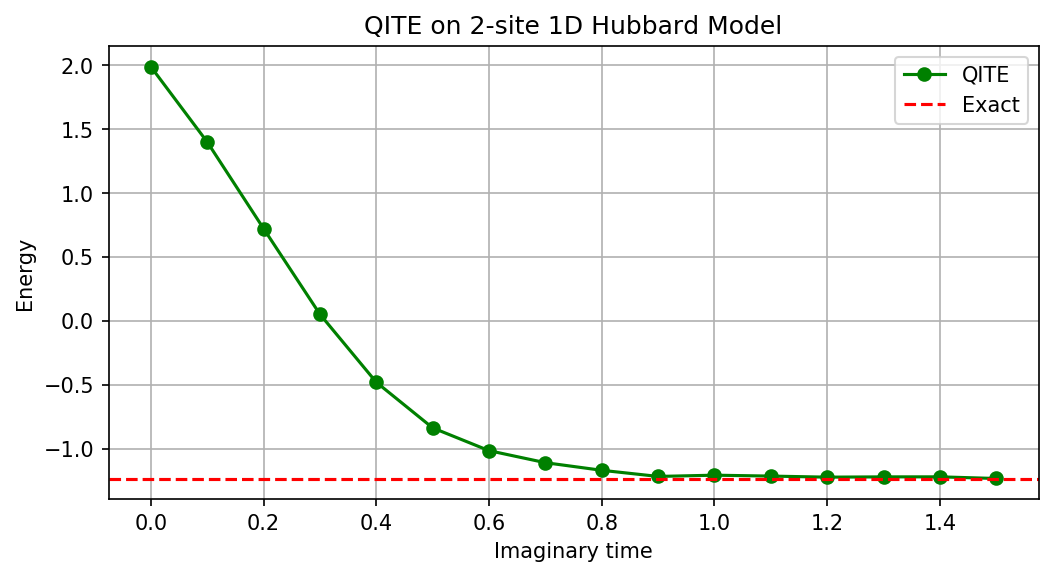

In [103]:
# some trouble with numpy sometimes because of imaginary part... so plot only real part of E
plt.figure(figsize=[8,4], dpi=150)
plt.plot(np.arange(0,len(alist)+1)*db,np.asarray(E).real,'g-o',label='QITE')
plt.axhline(y=-1.23607, color='r',linestyle='--',label="Exact")
plt.title("QITE on 2-site 1D Hubbard Model")
plt.xlabel("Imaginary time")
plt.ylabel("Energy")
plt.grid()
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

In [ ]:
def get_diff_between_lists(a,b):
    assert len(a) == len(b), print("go away")
    diff = [0]*len(a)
    for i in range(len(a)):
        diff[i] = a[i] - b[i]
        if diff[i] < 0.1:
            diff[i] = 0
    return diff

In [ ]:
classical_QITE_expectations = [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], [1.0000000000000002, 0.5875945241404422, -3.923726203155922e-15, 0.6459204807786503, 0.5875945241404403, 0.18614824179461656, 1.923208955806588e-14, 0.740361779529068, -2.69598713963591e-14, -7.172215547990212e-15, 0.48735962872487193, -3.2253584905223524e-14, 0.645920480778652, 0.7403617795290697, -3.2283289709909248e-15, 0.3264921294805118], [1.0000000000000002, 0.7915157699881595, -4.50114172275724e-15, 0.39684414982008476, 0.807703302314515, 0.7301186398241034, 8.064375058956748e-15, 0.5790759043206679, -2.0829204142415845e-14, -1.5933092339981455e-14, 0.4647768352807887, -1.543649790066658e-14, 0.3627642055338454, 0.5562746556647854, -3.676858096534116e-15, -0.19538137806672345], [1.0000000000000004, 0.867890844399881, -9.966852348246363e-16, 0.2113027586298094, 0.8762641064466875, 0.932511660115753, 6.297996200421643e-15, 0.31682394858543883, -1.4526865025196367e-14, -1.50457307445826e-14, 0.4495738275325809, -4.830649043206626e-15, 0.1733337513322032, 0.2928705310262461, 8.94520744852386e-17, -0.3826069364368522], [1.0, 0.8880188716055775, 2.0330351936456983e-15, 0.10826332909334507, 0.8913457947745356, 0.9844414254068399, 6.764152738764449e-15, 0.15834753250739575, -9.003353243038227e-15, -1.0971762400685826e-14, 0.44687977717276817, -1.5586394044098758e-15, 0.07616520788239584, 0.138398452002092, 3.578088545897458e-16, -0.43168106585901606], [1.0, 0.8928214358513773, 2.7962561491165784e-15, 0.05659598624710549, 0.8940863521108894, 0.9964386327086504, 6.133396127874399e-15, 0.07853174072739721, -6.021291744334e-15, -8.103920227416014e-15, 0.44684088669794153, -6.25832860630621e-16, 0.030705324359796726, 0.06250556444375899, 9.867087427572582e-17, -0.4435117240644378], [0.9999999999999996, 0.8939861808798093, 2.7649329737229557e-15, 0.030964316730694608, 0.8944634843343948, 0.9991576449313755, 5.239392917506069e-15, 0.0397346809241898, -4.2993334885783714e-15, -6.1835505976849725e-15, 0.44702339925929313, -2.3622165405028584e-16, 0.010254545676892518, 0.02692975426155747, 3.8031869907506855e-17, -0.44632932183286467], [0.9999999999999996, 0.8942892673660956, 2.463871733732257e-15, 0.017995753102450385, 0.8944691271509906, 0.9997816208955173, 4.343942764968707e-15, 0.020846800470907756, -3.1795939147178743e-15, -4.785698198506902e-15, 0.44712734108314905, -8.111891762539558e-17, 0.0014565128414519846, 0.010623718266539295, 2.2253953329321182e-17, -0.44700348676932855], [0.9999999999999997, 0.8943771785536929, 2.081326562324718e-15, 0.011191812370160092, 0.8944449364286997, 0.9999317730677142, 3.537364020821794e-15, 0.011506490811894476, -2.421044802394975e-15, -3.74724913887168e-15, 0.44717357459738855, -2.7245722347595406e-17, -0.0020124310801445666, 0.003345526195933368, 1.1685298068811762e-17, -0.4471655880672515], [0.9999999999999998, 0.8944062953239316, 1.7170644042909359e-15, 0.007436300632527759, 0.8944318201095054, 0.9999723198354711, 2.858247865174943e-15, 0.006761708740481931, -1.8771105594280365e-15, -2.9571455911121956e-15, 0.44719356023742374, -1.0902014819034393e-17, -0.003104650990796348, 0.0002469732139926961, 3.762758436787099e-18, -0.4472042689642268]]

In [ ]:
assert len(QITE_expectations) == len(classical_QITE_expectations), print("...")

diff_matrix = [0] * N
# should be N
for i in range(N):
    a = QITE_expectations[i]
    b = classical_QITE_expectations[i]
    diff_matrix[i] = get_diff_between_lists(a,b)

print(np.array(diff_matrix))